# SAEval

### Setup

In [2]:
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/jbloomAus/SAELens

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_18532/352175503.py:15: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_18532/352175503.py:16: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
import torch
import transformer_lens.utils as utils

import plotly.express as px
import tqdm
from functools import partial
import einops
import plotly.graph_objects as go
import numpy as np

update_layout_set = {
    "xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis",
     "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid",
     "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth"
}

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    if isinstance(tensor, list):
        tensor = torch.stack(tensor)
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0,labels={"x":xaxis, "y":yaxis}, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, return_fig=False, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    fig = px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs)
    if return_fig:
        return fig
    fig.show(renderer)

from typing import List
def show_avg_logit_diffs(x_axis: List[str], per_prompt_logit_diffs: List[torch.tensor]):


    y_data = [per_prompt_logit_diff.mean().item() for per_prompt_logit_diff in per_prompt_logit_diffs]
    error_y_data = [per_prompt_logit_diff.std().item() for per_prompt_logit_diff in per_prompt_logit_diffs] 

    fig = go.Figure(data=[go.Bar(
        x=x_axis,
        y=y_data,
        error_y=dict(
            type='data',  # specifies that the actual values are given
            array=error_y_data,  # the magnitudes of the errors
            visible=True  # make error bars visible
        ),
    )])

    # Customize layout
    fig.update_layout(title_text=f'Logit Diff after Interventions',
                    xaxis_title_text='Intervention',
                    yaxis_title_text='Logit diff',
                    plot_bgcolor='white')

    # Show the figure
    fig.show()

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os

os.environ['HF_HOME'] = '/workspace/huggingface/'

if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else: 
    device = "cpu"
torch.set_grad_enabled(False)

### Load model and data

In [5]:
from sae_lens import HookedSAETransformer

model: HookedSAETransformer = HookedSAETransformer.from_pretrained("gpt2").to(device)
#model.set_use_attn_in(True)
#model.set_use_attn_result(True)
#model.set_use_hook_mlp_in(True)
#model.set_use_split_qkv_input(True)

/workspace/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


In [6]:
import json

with open('tasks/ioi/task.json') as f:
    task = json.load(f)

In [7]:
task['prompts'][0]

{'prompt': 'When John and Mary went to the store, Mary gave a drink to',
 'variables': {'IO': 'John', 'S1': 'Mary', 'S2': 'Mary', 'Pos': 'ABB'}}

In [8]:
from functools import partial
import random
import re

# Computes logit difference between clean and corrupted answers tokens
def logits_diff(logits, correct_answer, incorrect_answer=None):
    correct_index = model.to_single_token(correct_answer)
    if incorrect_answer is None:
        return logits[0, -1, correct_index]
    else:
        incorrect_index = model.to_single_token(incorrect_answer)
        return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# Hooks used for patching
def zero_abl_hook(x, hook, pos, head):
    x[:, pos, head] = 0
    return x

def patching_hook(x, hook, pos, head, corr):
    x[:, pos, head] = corr[:, pos, head]
    return x

def feature_patching_hook(x, hook, pos, head, f_in, f_out):
    x[:, pos, head] = x[:, pos, head] + f_in[None, pos, head] - f_out[None, pos, head]
    return x

# Base class for circuits
class TransformerCircuit:
    def __init__(self, model, task):
        self.model = model
        self.task = task

    def get_node(self, node_name):
        for node in self.task['nodes']:
            if node['name'] == node_name:
                return node
        return None

    def get_variable(self, variable_name):
        for variable in self.task['variables']:
            if variable['name'] == variable_name:
                return variable
        return None

    @classmethod
    def read_variable(self, x):
        if '+' in x:
            offset = int(x.split('+')[-1])
        elif '-' in x:
            offset = int(x.split('-')[-1])
        else:
            offset = 0

        pattern = r"\{([^}]*)\}"
        return re.findall(pattern, x)[0], offset

# Class for IOI circuit
class IOICircuit(TransformerCircuit):
    def __init__(self, model, cfg):
        super().__init__(model, cfg)
        self.names = self.get_variable('IO')['values']
        self.components = ['q', 'k', 'v', 'z']

    def run_with_patch(
            self, 
            prompt: dict, 
            node_names: str, 
            attribute: str, 
            method: str ='zero',
            patches: list=None,
            verbose: bool=False):
        '''
        Function to run the circuit with a patch applied to the specified nodes.
        Takes in:
        - prompt: the prompt instance to be used
        - node_names: the names of the nodes to be patched
        - attribute: the attribute of the task to be patched
        - method: the method to be used for patching (one of 'zero', 'corr', 'feature')
        - patches: the patches to be applied to the nodes if using 'feature' method

        Returns the difference of answer logits between the clean and patched prompt.
        '''
        # Checks
        assert method in ['zero', 'corr', 'feature'], "Method must be either 'zero', 'corr', 'feature'"
        assert attribute in ['IO', 'S', 'Pos'], "Attribute must be either 'IO', 'S', 'Pos'"
        for node_name in node_names:
            node, components = node_name.split('.')
            assert self.get_node(node) is not None, f"Node {node_name} not found in the task"
            for c in components:
                assert c in self.components, f"Component {c} not found in the task"
        
        # Extracting variables from the prompt
        io = ' '+prompt['variables']['IO']
        s = ' '+prompt['variables']['S1']
        pos = prompt['variables']['Pos']
        pos = 0 if pos == "ABB" else 1

        clean_prompt = prompt['prompt']
        clean_tokens = model.to_tokens(clean_prompt)
        if verbose: print(f"Clean prompt: {clean_prompt}")

        new_io = None
        if method == 'corr':
            # Creation of the corrupted prompt based on the attribute
            if attribute == 'IO':
                # Pick a random new name to put in IO
                new_io = ' ' + random.choice(list(set(self.names) - {io[1:], s[1:]}))
                corr_prompt = clean_prompt.replace(io, new_io)
            elif attribute == 'S':
                # Pick a random new name to put in S
                new_s = ' ' + random.choice(list(set(self.names) - {io[1:], s[1:]}))
                corr_prompt = clean_prompt.replace(s, new_s)
            elif attribute == 'Pos':
                # Generate a new prompt with the opposite template
                new_template = self.task['templates'][1-pos]
                corr_prompt = new_template.format(IO=io[1:], S1=s[1:], S2=s[1:])

            corr_tokens = model.to_tokens(corr_prompt)
            if verbose: print(f"Corrupted prompt: {corr_prompt}")
            
            with torch.no_grad():
                _, corr_cache = self.model.run_with_cache(corr_tokens)

        with torch.no_grad():
            clean_logits = self.model(clean_tokens)
        
        # Hooking the model for patching
        hooks = []

        for name in node_names:
            # Split the node name into components (e.g. IH.qk -> IH, qk)
            node_name, components = name.split('.')
            node = self.get_node(node_name)

            # Add hooks to selected component of the node
            for component_name in components:
                if component_name in ['q', 'z']:
                    # Read the variable name and offset (e.g. IH.q -> S2+0 | PTH.z -> S1+1)
                    var, offset = self.read_variable(node['q'])
                else:
                    var, offset = self.read_variable(node['kv'])

                # Retrieve the token position of the variable
                var_pos = self.get_variable(var)['position'][pos] + offset

                # Add hooks to the component of each node head
                for head in node['heads']:
                    l, h = head.split('.')
                    hook_name = utils.get_act_name(component_name, int(l))
                    
                    if method == 'zero':
                        hook_fn = partial(zero_abl_hook, pos=var_pos, head=int(h))
                    elif method == 'corr':
                        hook_fn = partial(patching_hook, pos=var_pos, head=int(h), corr=corr_cache[hook_name])
                    elif method == 'feature':
                        f_in = patches[0][component_name][int(l)]
                        f_out = patches[1][component_name][int(l)]
                        hook_fn = partial(feature_patching_hook, pos=var_pos, head=int(h), f_in=f_in, f_out=f_out)

                    hooks.append((hook_name, hook_fn))
                    if verbose: print(f"Hooking L{l}H{h} {component_name} at position {var_pos}")

        with torch.no_grad():
            patched_logits = model.run_with_hooks(clean_tokens, fwd_hooks=hooks)

        return new_io, clean_logits, patched_logits

In [9]:
ioi_circuit = IOICircuit(model, task)

In [10]:
example = task['prompts'][0]
io = ' '+example['variables']['IO']
s = ' '+example['variables']['S1']

new_io, clean_logits, patched_logits = ioi_circuit.run_with_patch(
    example, 
    node_names=['NMH.z', 'bNMH.z'],
    attribute='IO',
    method='corr',
    verbose=True 
    )

print("\nClean logit diff: ", np.round(logits_diff(clean_logits, io, new_io).item(), 2))
print("Patched logit diff: ", np.round(logits_diff(patched_logits, io, new_io).item(), 2))

Clean prompt: When John and Mary went to the store, Mary gave a drink to
Corrupted prompt: When Brian and Mary went to the store, Mary gave a drink to
Hooking L9H6 z at position -1
Hooking L9H9 z at position -1
Hooking L10H0 z at position -1
Hooking L9H0 z at position -1
Hooking L9H7 z at position -1
Hooking L10H1 z at position -1
Hooking L10H2 z at position -1
Hooking L10H6 z at position -1
Hooking L10H10 z at position -1
Hooking L11H2 z at position -1
Hooking L11H9 z at position -1

Clean logit diff:  8.19
Patched logit diff:  -6.91


## Eval

In [11]:
from tqdm.auto import tqdm

def get_task_activations(prompts, bs=64):
    activations = {i: [] for i in ['q', 'k', 'v', 'z']}
    for b in tqdm(range(0, len(prompts), bs)):
        tokens = model.to_tokens(prompts[b:b+bs])
        
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens)

        for key in activations.keys():
            activations[key].append(cache.stack_activation(key))

    return {key: torch.cat(values, 1) for key, values in activations.items()}

In [12]:
prompts = [p['prompt'] for p in task['prompts']]
activations = get_task_activations(prompts)

 53%|█████▎    | 8/15 [00:00<00:00, 23.43it/s]

100%|██████████| 15/15 [00:00<00:00, 24.73it/s]


In [13]:
import pandas as pd

task_df = {
    'prompt': [],
    'IO': [],
    'S1': [],
    'S2': [],
    'Pos': [],
    'IO_pos': [],
    'S1_pos': [],
    'S2_pos': []
}

for i, prompt in enumerate(task['prompts']):
    task_df['prompt'].append(prompt['prompt'])
    task_df['IO'].append(prompt['variables']['IO'])
    task_df['S1'].append(prompt['variables']['S1'])
    task_df['S2'].append(prompt['variables']['S2'])

    pos = prompt['variables']['Pos']
    pos = 0 if pos == "ABB" else 1
    task_df['Pos'].append(pos)

    io_pos = ioi_circuit.get_variable('IO')['position'][pos]
    s1_pos = ioi_circuit.get_variable('S1')['position'][pos]
    s2_pos = ioi_circuit.get_variable('S2')['position'][pos]

    task_df['IO_pos'].append(io_pos)
    task_df['S1_pos'].append(s1_pos)
    task_df['S2_pos'].append(s2_pos)

task_df = pd.DataFrame(task_df)

In [14]:
task_df

,prompt,IO,S1,S2,Pos,IO_pos,S1_pos,S2_pos
0,"When John and Mary went to the store, Mary gav...",John,Mary,Mary,0,2,4,10
1,"When Paul and John went to the store, Paul gav...",John,Paul,Paul,1,4,2,10
2,"When Anna and John went to the store, Anna gav...",John,Anna,Anna,1,4,2,10
3,"When John and Mark went to the store, Mark gav...",John,Mark,Mark,0,2,4,10
4,"When Lucy and John went to the store, Lucy gav...",John,Lucy,Lucy,1,4,2,10
...,...,...,...,...,...,...,...,...
925,"When Molly and Megan went to the store, Megan ...",Molly,Megan,Megan,0,2,4,10
926,"When Molly and Ryan went to the store, Ryan ga...",Molly,Ryan,Ryan,0,2,4,10
927,"When Julie and Molly went to the store, Julie ...",Molly,Julie,Julie,1,4,2,10
928,"When Steve and Molly went to the store, Steve ...",Molly,Steve,Steve,1,4,2,10


### Supervised dictionary

In [15]:
names = ioi_circuit.get_variable('IO')['values']


def ioi_supervised_dictionary(df, activations):
    
    io_vec = {
        'ABB': {},
        'BAB': {}
    }
    s_vec = {
        'ABB': {},
        'BAB': {}
    }

    for name in names:
        io_vec['ABB'][name] = {}
        io_vec['BAB'][name] = {}
        s_vec['ABB'][name] = {}
        s_vec['BAB'][name] = {}

        for c in ['q', 'k', 'v', 'z']:
            centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]
            mask = (df['IO'] == name) & (df['Pos'] == 0)
            io_vec['ABB'][name][c] = centered_activations[:, mask].mean(1)

            mask = (df['IO'] == name) & (df['Pos'] == 1)
            io_vec['BAB'][name][c] = centered_activations[:, mask].mean(1)

            mask = (df['S1'] == name) & (df['Pos'] == 0)
            s_vec['ABB'][name][c] = centered_activations[:, mask].mean(1)

            mask = (df['S1'] == name) & (df['Pos'] == 1)
            s_vec['BAB'][name][c] = centered_activations[:, mask].mean(1)

    # Pos
    pos_vec = {
        'ABB': {},
        'BAB': {}
    }

    for c in ['q', 'k', 'v', 'z']:
        centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]
        mask = df['Pos'] == 0
        pos_vec['ABB'][c] = centered_activations[:, mask].mean(1)

        mask = df['Pos'] == 1
        pos_vec['BAB'][c] = centered_activations[:, mask].mean(1)
    
    return (io_vec, s_vec, pos_vec)
"""

def ioi_supervised_dictionary(df, activations):
    
    components = ['q', 'k', 'v', 'z']
    io_vec = {}
    s_vec = {}
    pos_vec = {'ABB': {}, 'BAB': {}}

    for name in names:
        io_vec[name] = {}
        s_vec[name] = {}
        
        for c in components:
            centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]
            
            # IO
            mask = (df['IO'] == name)
            io_vec[name][c] = centered_activations[:, mask].mean(1)

            mask = (df['S1'] == name)
            s_vec[name][c] = centered_activations[:, mask].mean(1)

    # Pos
    for c in components:
        centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]
        mask = df['Pos'] == 0
        pos_vec['ABB'][c] = centered_activations[:, mask].mean(1)
        pos_vec['BAB'][c] = centered_activations[:, ~mask].mean(1)
    
    return (io_vec, s_vec, pos_vec)
"""

"\n\ndef ioi_supervised_dictionary(df, activations):\n    \n    components = ['q', 'k', 'v', 'z']\n    io_vec = {}\n    s_vec = {}\n    pos_vec = {'ABB': {}, 'BAB': {}}\n\n    for name in names:\n        io_vec[name] = {}\n        s_vec[name] = {}\n        \n        for c in components:\n            centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]\n            \n            # IO\n            mask = (df['IO'] == name)\n            io_vec[name][c] = centered_activations[:, mask].mean(1)\n\n            mask = (df['S1'] == name)\n            s_vec[name][c] = centered_activations[:, mask].mean(1)\n\n    # Pos\n    for c in components:\n        centered_activations = activations[c] - activations[c].mean(2).mean(1)[:, None, None]\n        mask = df['Pos'] == 0\n        pos_vec['ABB'][c] = centered_activations[:, mask].mean(1)\n        pos_vec['BAB'][c] = centered_activations[:, ~mask].mean(1)\n    \n    return (io_vec, s_vec, pos_vec)\n"

In [24]:
io_vec, s_vec, pos_vec = ioi_supervised_dictionary(task_df, activations)

In [29]:
idx = 0

nodes = ['NMH.z', 'bNMH.z']
attribute = 'IO'

example = task['prompts'][idx]

io = example['variables']['IO']
s = example['variables']['S2']
pos = example['variables']['Pos']

neg_pos = 'ABB' if pos == 'BAB' else 'BAB'

In [30]:
new_io, clean_logits, patched_logits = ioi_circuit.run_with_patch(
    example, 
    node_names=nodes,
    attribute=attribute,
    method='corr',
    verbose=True 
    )

print("\nClean logit diff: ", np.round(logits_diff(clean_logits, ' '+io, new_io).item(), 2))
print("Patched logit diff: ", np.round(logits_diff(patched_logits, ' '+io, new_io).item(), 2))

Clean prompt: When John and Mary went to the store, Mary gave a drink to
Corrupted prompt: When Kevin and Mary went to the store, Mary gave a drink to
Hooking L9H6 z at position -1
Hooking L9H9 z at position -1
Hooking L10H0 z at position -1
Hooking L9H0 z at position -1
Hooking L9H7 z at position -1
Hooking L10H1 z at position -1
Hooking L10H2 z at position -1
Hooking L10H6 z at position -1
Hooking L10H10 z at position -1
Hooking L11H2 z at position -1
Hooking L11H9 z at position -1

Clean logit diff:  8.62
Patched logit diff:  -5.28


In [31]:
node, component = nodes[0].split('.')

if attribute == 'IO':
    in_patch = io_vec[pos][new_io[1:]]
    out_patch = s_vec[pos][io]
elif attribute == 'S':
    in_patch = io_vec[pos][new_io[1:]]
    out_patch = s_vec[pos][s]
else:
    in_patch = pos_vec[pos]
    out_patch = pos_vec[neg_pos]

In [32]:
_, clean_logits, patched_logits = ioi_circuit.run_with_patch(
    example, 
    node_names=nodes,
    attribute=attribute,
    method='feature',
    patches=(in_patch, out_patch),
    verbose=True
    )

print("\nClean logit diff: ", np.round(logits_diff(clean_logits, ' '+io, new_io).item(), 2))
print("Patched logit diff: ", np.round(logits_diff(patched_logits, ' '+io, new_io).item(), 2))

Clean prompt: When John and Mary went to the store, Mary gave a drink to
Hooking L9H6 z at position -1
Hooking L9H9 z at position -1
Hooking L10H0 z at position -1
Hooking L9H0 z at position -1
Hooking L9H7 z at position -1
Hooking L10H1 z at position -1
Hooking L10H2 z at position -1
Hooking L10H6 z at position -1
Hooking L10H10 z at position -1
Hooking L11H2 z at position -1
Hooking L11H9 z at position -1

Clean logit diff:  8.62
Patched logit diff:  -1.88


### SAE dictionary

In [34]:
from sae_lens import SAE

hook_name_to_sae = {}
for layer in tqdm(range(12)):
    sae, cfg_dict, _ = SAE.from_pretrained(
        "gpt2-small-hook-z-kk",
        f"blocks.{layer}.hook_z",
        device=device,
    )
    hook_name_to_sae[sae.cfg.hook_name] = sae
    

print(hook_name_to_sae.keys())

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:56<00:00, 14.75s/it]

dict_keys(['blocks.0.attn.hook_z', 'blocks.1.attn.hook_z', 'blocks.2.attn.hook_z', 'blocks.3.attn.hook_z', 'blocks.4.attn.hook_z', 'blocks.5.attn.hook_z', 'blocks.6.attn.hook_z', 'blocks.7.attn.hook_z', 'blocks.8.attn.hook_z', 'blocks.9.attn.hook_z', 'blocks.10.attn.hook_z', 'blocks.11.attn.hook_z'])


In [44]:
idx = 0

node_names = ['NMH.z', 'bNMH.z']
attribute = 'IO'

example = task['prompts'][idx]

io = example['variables']['IO']
s = example['variables']['S2']

pos = example['variables']['Pos']
neg_pos = 'ABB' if pos == 'BAB' else 'BAB'

pos_id = 0 if pos == 'ABB' else 1

In [40]:
clean_prompt = example['prompt']
corr_prompt = clean_prompt.replace(' '+io, new_io)

clean_tokens = model.to_tokens(clean_prompt)
corr_tokens = model.to_tokens(corr_prompt)

In [162]:
# Hooking the model for patching
hooks = []

for name in node_names:
    # Split the node name into components (e.g. IH.qk -> IH, qk)
    node_name, components = name.split('.')
    node = ioi_circuit.get_node(node_name)
    print(f"\nHooking {components} of {node_name}...")

    # Add hooks to selected component of the node
    for component_name in components:
        if component_name in ['q', 'z']:
            # Read the variable name and offset (e.g. IH.q -> S2+0 | PTH.z -> S1+1)
            var, offset = ioi_circuit.read_variable(node['q'])
        else:
            var, offset = ioi_circuit.read_variable(node['kv'])

        # Retrieve the token position of the variable
        var_pos = ioi_circuit.get_variable(var)['position'][pos_id] + offset

        # Add hooks to the component of each node head
        for head in node['heads']:
            l, h = head.split('.')
            l, h = int(l), int(h)
            print(f"Hooking L{l}H{h} {component_name} at position {var_pos}")
            hook_name = utils.get_act_name(component_name, l)

            sae = hook_name_to_sae[hook_name]

            #with torch.no_grad():
            _, clean_cache = model.run_with_cache(clean_tokens)
            _, corr_cache = model.run_with_cache(corr_tokens)

            clean_acts = torch.matmul(clean_cache[hook_name][:, var_pos, h], model.W_O[l, h])
            corr_acts = torch.matmul(corr_cache[hook_name][:, var_pos, h], model.W_O[l, h])
            
            with torch.no_grad():
                _, sae_cache = sae.run_with_cache(clean_acts)

            sae_acts = sae_cache[hook_name + '.hook_sae_acts_post'][None]
            #corr_sae_acts = corr_sae_cache[hook_name + '.hook_sae_acts_post'][None]
# Parallelizable?


Hooking z of NMH...
Hooking L9H6 z at position -1
Hooking L9H9 z at position -1
Hooking L10H0 z at position -1



Hooking z of bNMH...
Hooking L9H0 z at position -1
Hooking L9H7 z at position -1
Hooking L10H1 z at position -1
Hooking L10H2 z at position -1
Hooking L10H6 z at position -1
Hooking L10H10 z at position -1
Hooking L11H2 z at position -1
Hooking L11H9 z at position -1


In [131]:
def l2_dist(a, b):
    return (a - b).norm(2, -1)

f_in = []
f_out = []

hat_clean_acts = clean_acts.clone()
hat_corr_acts = corr_acts.clone()

dm, dsae = sae.W_dec.shape

for i in range(4):
    
    for j in f_out:
        hat_clean_acts = hat_clean_acts - sae.W_dec[j, None, :] * sae_acts[:, j]
    for j in f_in:
        hat_corr_acts = hat_corr_acts + sae.W_dec[j, None, :] * sae_acts[:, j]
    
    base_dist = l2_dist(hat_clean_acts, hat_corr_acts)
    k_in = []
    k_out = []

    for j in range(dsae):
        tilde_clean_acts = hat_clean_acts - sae.W_dec[i, None, :]
        tilde_corr_acts = hat_corr_acts + sae.W_dec[i, None, :]
        
        k_in.append(l2_dist(hat_clean_acts, tilde_corr_acts) / base_dist)
        k_out.append(l2_dist(tilde_clean_acts, hat_corr_acts) / base_dist)

    k_in = torch.cat(k_in)
    k_out = torch.cat(k_out)

    best_k_in, best_k_in_id = k_in.min(), k_in.argmin()
    best_k_out, best_k_out_id = k_out.min(), k_out.argmin()

    f_in.append(best_k_in_id)
    f_out.append(best_k_out_id)

    print(best_k_in, best_k_out)

tensor(1.0100, device='cuda:0') tensor(1.0100, device='cuda:0')
tensor(1.0133, device='cuda:0') tensor(1.0133, device='cuda:0')
tensor(1.0123, device='cuda:0') tensor(1.0123, device='cuda:0')


tensor(1.0074, device='cuda:0') tensor(1.0074, device='cuda:0')


## Dataset Eval 

In [71]:
nodes = [...]

patch_df = {
    'Component': [],
    'Method': [],
    'Value': [],
    'Node': []
}

for i in tqdm(range(256)):
    
    example = task['prompts'][i]
    io = example['variables']['IO']
    s2 = example['variables']['S2']
    pos = example['variables']['Pos']
    
    for c, node in nodes:
        in_patch = s2_vec[c][pos][io]
        out_patch = s2_vec[c][pos][s2]
        
        for method in ['zero', 'corr', 'feature']:
            f_patch = ioi_circuit.run_with_patch(example, node, c, method=method, patches=(in_patch, out_patch))
            patch_df['Component'].append(c)
            patch_df['Method'].append(method)
            patch_df['Value'].append(f_patch.item())
            patch_df['Node'].append('-'.join(node))

patch_df = pd.DataFrame(patch_df)

  0%|          | 0/256 [00:00<?, ?it/s]

In [73]:
patch_df

,Component,Method,Value,Node
0,z,zero,1.831372,IH-DTH
1,z,corr,2.929109,IH-DTH
2,z,feature,0.430950,IH-DTH
3,v,zero,2.044028,SIH
4,v,corr,4.813996,SIH
...,...,...,...,...
3835,q,corr,1.034420,bNMH
3836,q,feature,0.519292,bNMH
3837,z,zero,0.028261,bNMH
3838,z,corr,0.519850,bNMH


In [74]:
import numpy as np

ids = np.arange(256)[:, None].repeat(15, axis=-1).ravel()
patch_df['id'] = ids

In [75]:
patch_df

,Component,Method,Value,Node,id
0,z,zero,1.831372,IH-DTH,0
1,z,corr,2.929109,IH-DTH,0
2,z,feature,0.430950,IH-DTH,0
3,v,zero,2.044028,SIH,0
4,v,corr,4.813996,SIH,0
...,...,...,...,...,...
3835,q,corr,1.034420,bNMH,255
3836,q,feature,0.519292,bNMH,255
3837,z,zero,0.028261,bNMH,255
3838,z,corr,0.519850,bNMH,255


In [84]:
w_patch_df = patch_df.pivot_table(index=['id', 'Node', 'Component'], columns='Method', values='Value')
w_patch_df['Score'] =  w_patch_df['feature'] / w_patch_df['corr']

In [85]:
w_patch_df

Method                    corr   feature      zero     Score
id  Node   Component                                        
0   IH-DTH z          2.929109  0.430950  1.831372  0.147127
    SIH    v          4.813996  1.566894  2.044028  0.325487
           z          5.658517  1.875863  2.200246  0.331511
    bNMH   q          1.361876  0.507788  1.747836  0.372859
           z          1.058905 -1.265417  0.577203 -1.195025
...                        ...       ...       ...       ...
255 IH-DTH z          6.300706 -0.212787  3.578847 -0.033772
    SIH    v          7.464174  0.535233  3.449300  0.071707
           z          6.680430  0.880195  3.822978  0.131757
    bNMH   q          1.034420  0.519292  1.657770  0.502013
           z          0.519850 -2.415362  0.028261 -4.646270

[1280 rows x 4 columns]

In [86]:
plot_df = w_patch_df.reset_index().groupby(['Node', 'Component']).mean().reset_index()
plot_df['Patch'] = plot_df.apply(lambda x: x['Node'] + ' ' + x['Component'], axis=1)

In [90]:
plot_df

Method,Node,Component,id,corr,feature,zero,Score,Patch
0,IH-DTH,z,127.5,5.009788,0.158037,2.799603,0.021792,IH-DTH z
1,SIH,v,127.5,7.365868,1.803261,2.982615,0.226621,SIH v
2,SIH,z,127.5,7.634843,2.098055,3.036329,0.254238,SIH z
3,bNMH,q,127.5,0.988175,1.463204,0.836795,1.887631,bNMH q
4,bNMH,z,127.5,0.829312,-2.521029,-0.229814,-4.239377,bNMH z


<Axes: xlabel='Patch', ylabel='Score'>

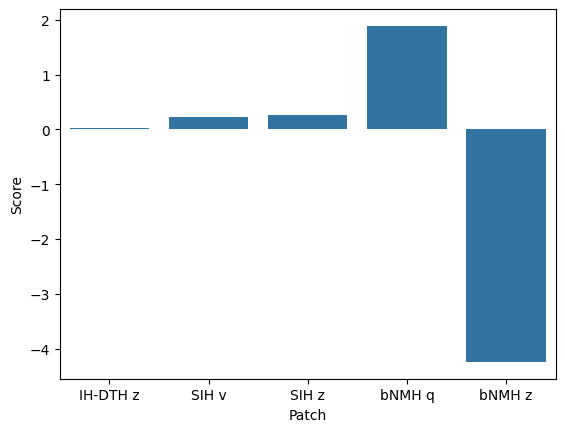

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(plot_df, x='Patch', y='Score')
#plt.ylim((-15, 15))